# Koopman delay embeddings assesment process
## 1 - Data gathering

In [81]:
import numpy as np
from numpy import random
from numpy import linalg as lg
from scipy import linalg as slg
from importlib import reload
import seaborn as snb
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.Functions import *
import pbdlib as pbd
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
np.set_printoptions(precision=5, suppress=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
print(1%5)

1


### Pendulum model-free control with references $R_1$ and $R_2$

(<matplotlib.legend.Legend at 0x1e2beaec280>,
 <matplotlib.legend.Legend at 0x1e2beadf2b0>)

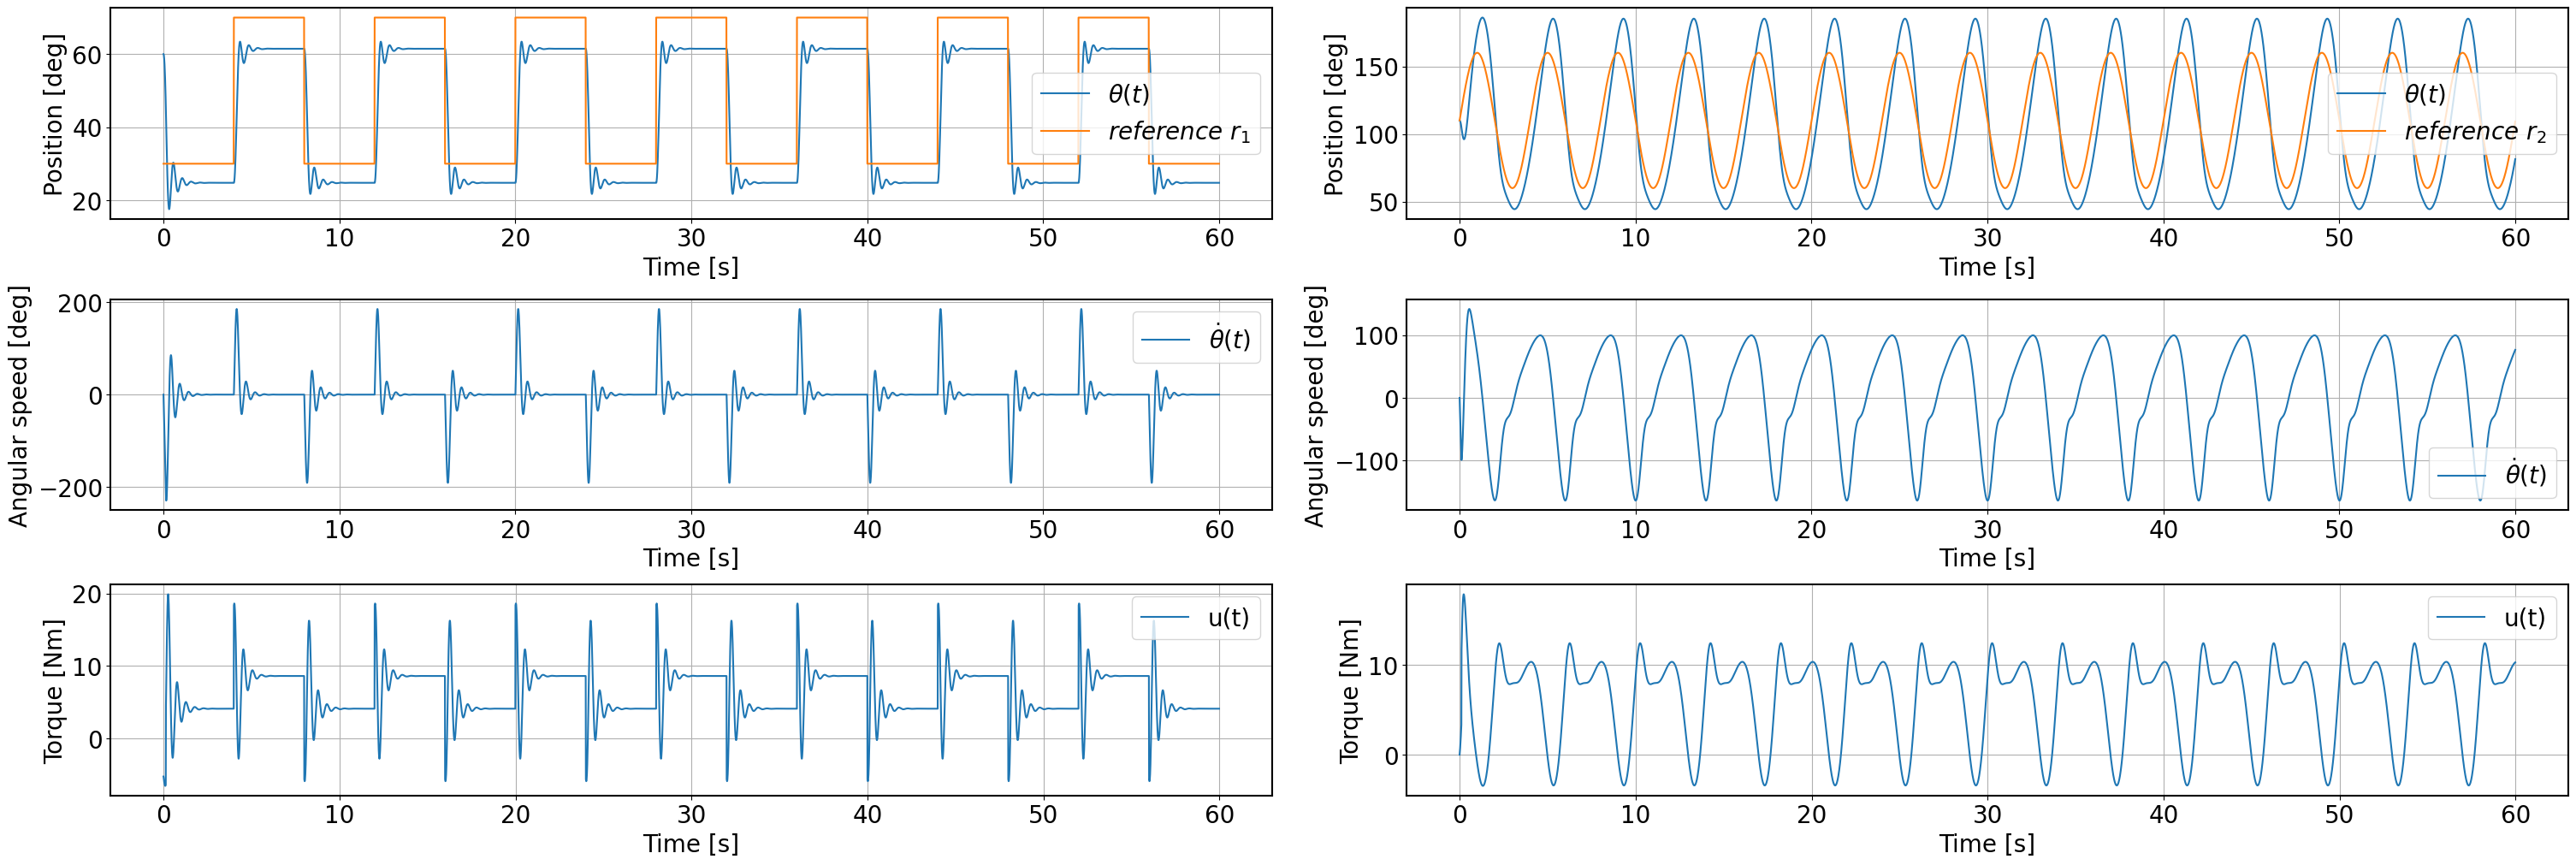

In [188]:
# Pendulum instance
dt = 1e-2
pend1 = SimplePendulum(mass=1, length=1, time=np.arange(0,60,dt), X0=np.array([deg2rad(60),0]), dt=dt)
pend2 = SimplePendulum(mass=1, length=1, time=np.arange(0,60,dt), X0=np.array([deg2rad(110),0]), dt=dt)

# Controller design
K, Ki, Kd, t_max = 10, 50, 0, 12

# Reference design
freq = .25
pend1.T_ref, pend2.T_ref = 1/freq/pend1.dt, 1/freq/pend2.dt
amplitude1, amplitude2 = 30, 50 # deg
pend1.ref = sineReference(pend1.N, pend1.dt, pend1.T_ref, amplitude1, 60)
pend1.ref = sineReference(pend1.N, pend1.dt, [], [], offset=60, varying=True, freq_vector=[.4], amp_vector=[30])
pend1.ref, precision = squareReference(pend1.N, pend1.T_ref, [deg2rad(70),deg2rad(30)], np.int(pend1.T_ref/10), 0)
pend2.ref = sineReference(pend1.N, pend1.dt, pend2.T_ref, amplitude2, 110)

# Simulation

for i in range(pend1.N-1):
    pend1.U[i] = PID(pend1.X, i, pend1.ref[i], 10, 1, 40, pend1.dt, 13, limit=20)[0]
    pend1.X[:,i+1] = RK4(pend1.dynamics, pend1.X[:,i], pend1.U[i], pend1.dt, type='controller-step-by-step')
    pend2.U[i] = PID(pend2.X, i, pend2.ref[i], 15, 0, 25, pend2.dt, 10, limit=20)[0]
    pend2.X[:,i+1] = RK4(pend2.dynamics, pend2.X[:,i], pend2.U[i], pend2.dt, type='controller-step-by-step')
    
# Plots
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(3, 2, 
                       constrained_layout = True, figsize=(30,10))

ax[0,0].plot(pend1.T, rad2deg(pend1.X[0,:]), label=r"$\theta (t)$")
ax[0,0].plot(pend1.T, rad2deg(np.array(pend1.ref)), label=r"$reference \ r_1$")
ax[0,1].plot(pend2.T, rad2deg(pend2.X[0,:]), label=r"$\theta (t)$")
ax[0,1].plot(pend1.T, rad2deg(np.array(pend2.ref)), label=r"$reference \ r_2$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]'), ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Position [deg]')
ax[0,0].grid(), ax[0,1].grid()
ax[0,0].legend(), ax[0,1].legend()

ax[1,0].plot(pend1.T, rad2deg(pend1.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,1].plot(pend1.T, rad2deg(pend2.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Angular speed [deg]'), ax[1,1].set_xlabel('Time [s]'), ax[1,1].set_ylabel('Angular speed [deg]')
ax[1,0].grid(), ax[1,1].grid()
ax[1,0].legend(), ax[1,1].legend()

ax[2,0].plot(pend1.T[:pend1.N-1], pend1.U, label='u(t)')
ax[2,1].plot(pend1.T[:pend1.N-1], pend2.U, label='u(t)')
ax[2,0].set_xlabel('Time [s]'), ax[2,0].set_ylabel('Torque [Nm]'), ax[2,1].set_xlabel('Time [s]'), ax[2,1].set_ylabel('Torque [Nm]')
ax[2,0].grid(), ax[2,1].grid()
ax[2,0].legend(), ax[2,1].legend()

## Linear dynamics learning

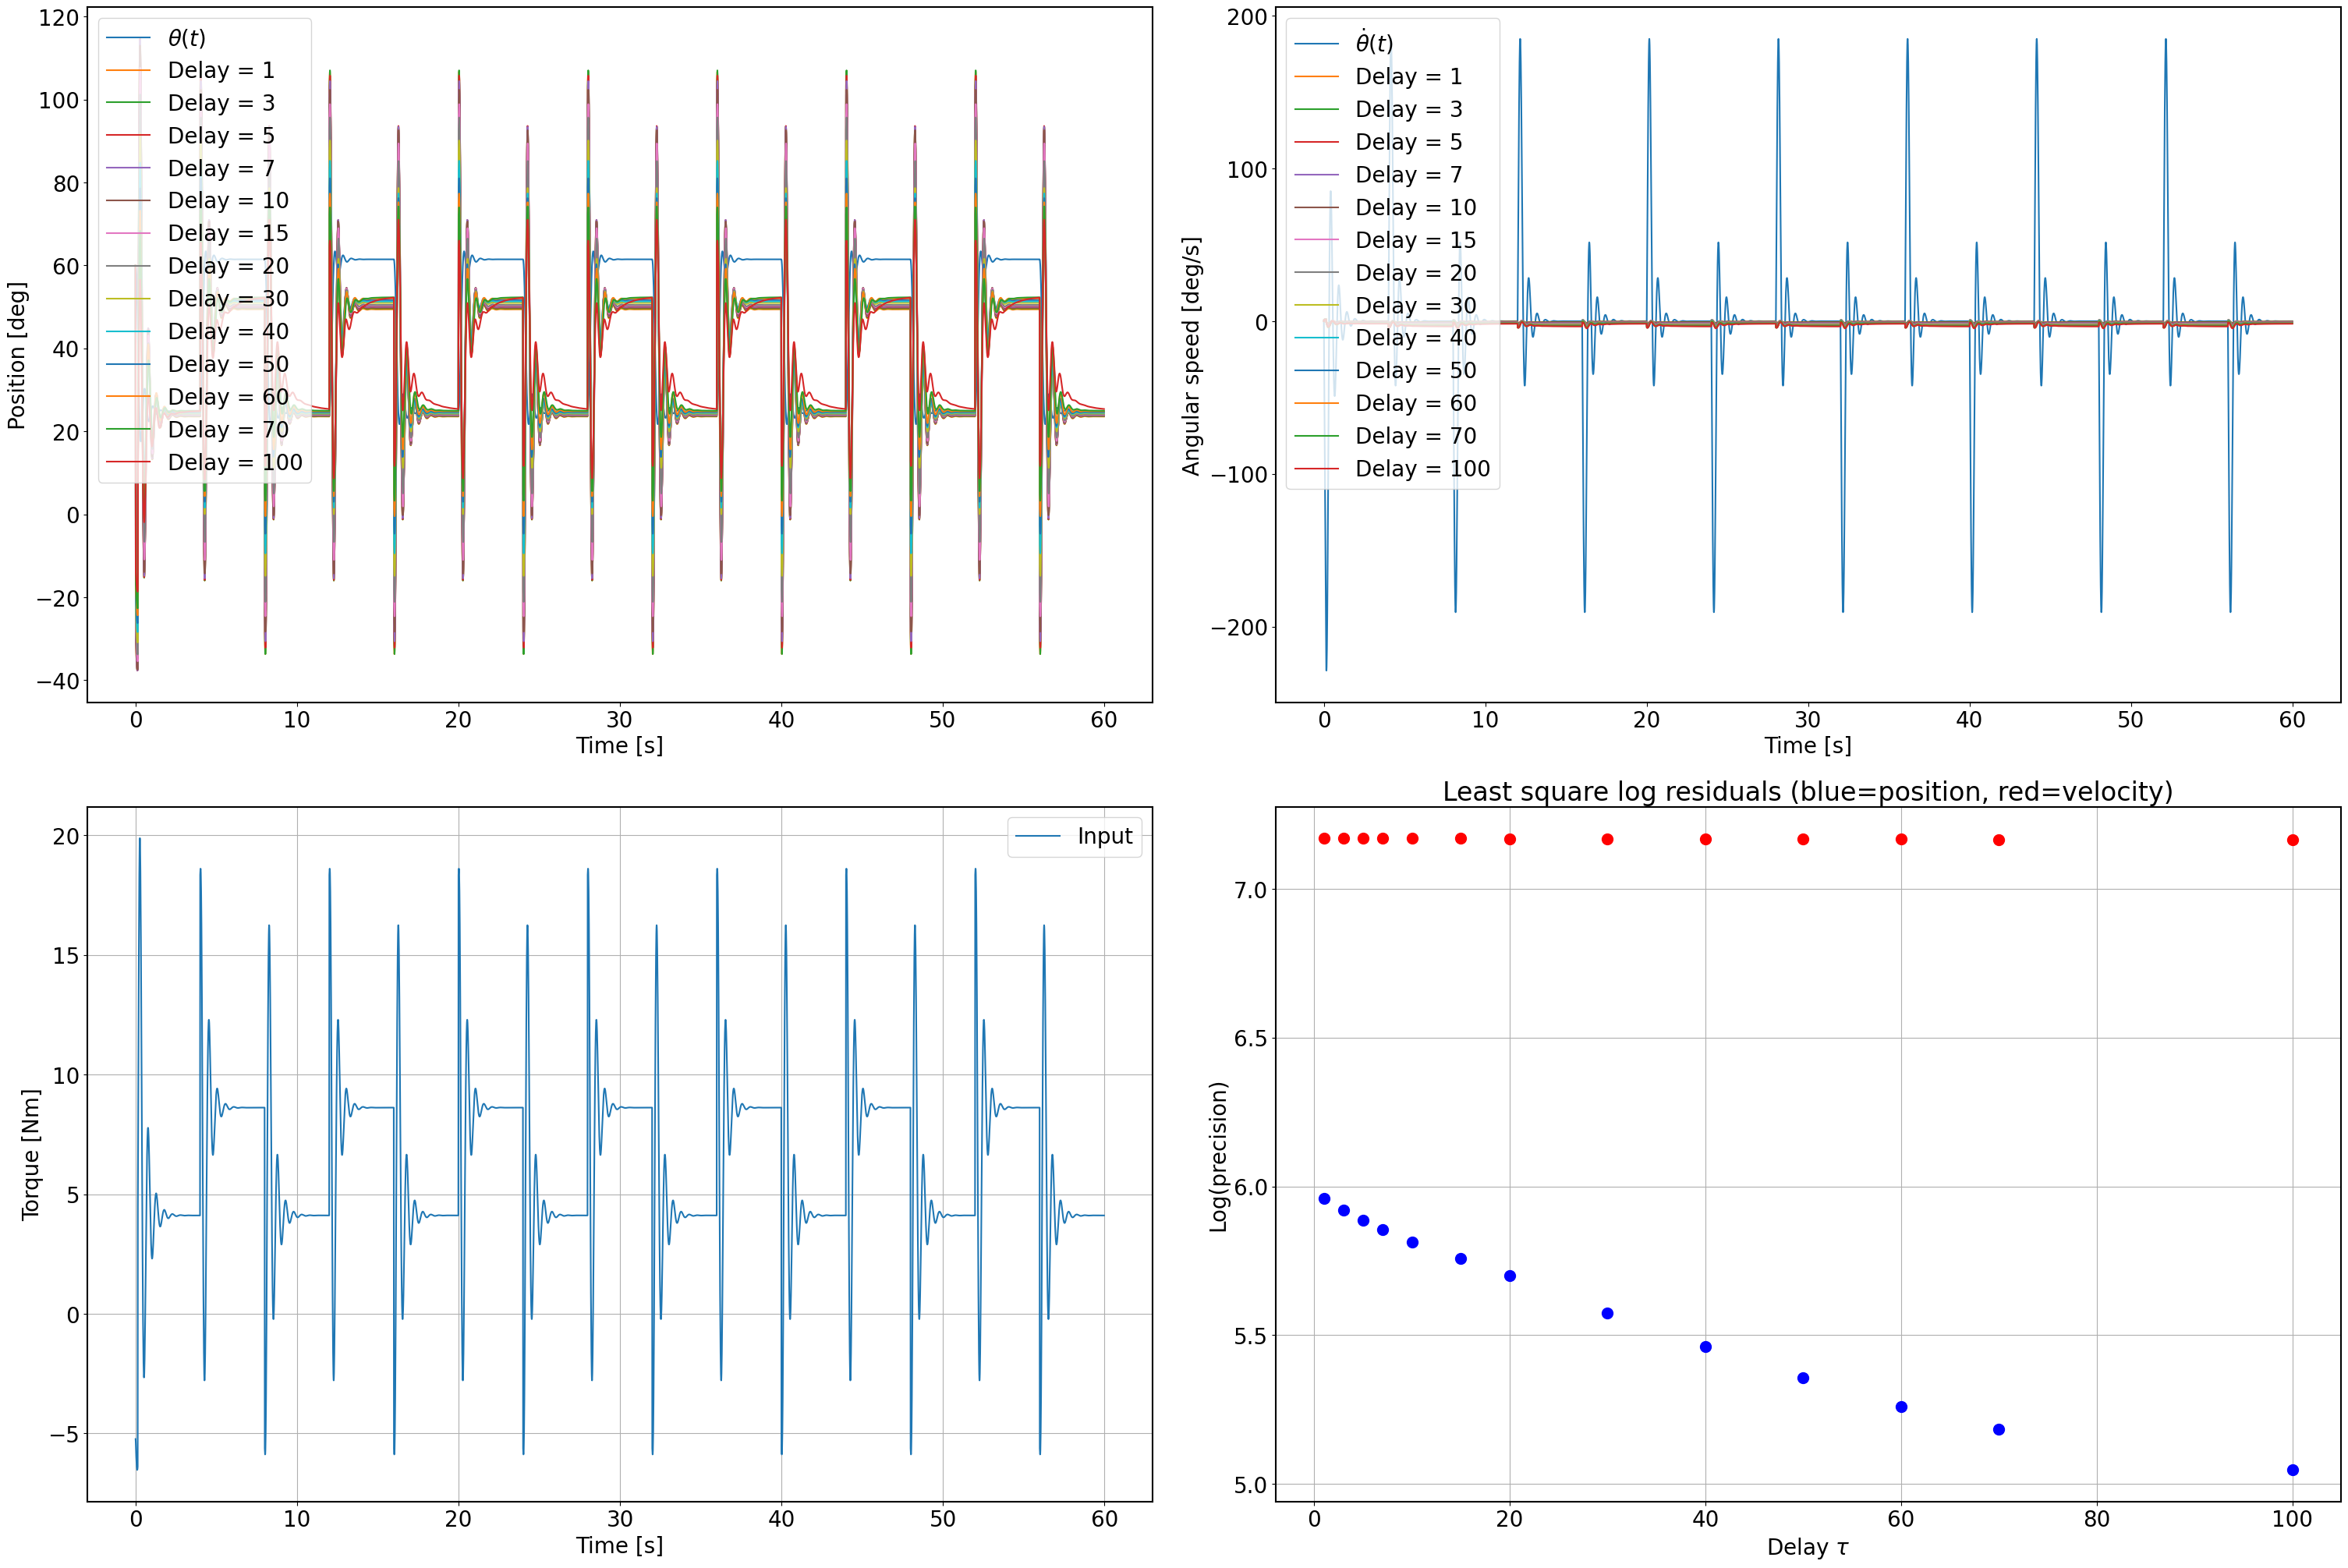

In [191]:
# Parameters
pend = pend1
horizon = np.int(pend.N/2)
nb_delay = [1,3,5,7,10,15,20,30,40,50,60,70,100]
nb_plots = len(nb_delay)
explained_var = .1 # Truncation of the U, Sigma and V matrices

plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(2, 2, constrained_layout = True, figsize=(30,20))

ax[0,0].plot(pend.T, rad2deg(pend.X[0,:]), label=r"$\theta (t)$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(pend.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:len(pend.T)-1], pend.U, label='Input')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

for i in range(nb_plots):
    tau = nb_delay[i]
    f1 = DelayedLeastSquare(pend.X, tau, horizon, pend.U[:], nb_u=1)
    f1.solve(.99)
    f1.computeTrajectory(pend.X0, pend.U)
    
    ax[0,0].plot(pend.T[:len(pend.T)], rad2deg(f1.Traj[0,:]), label='Delay = '+str(tau))
    ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
    ax[0,0].grid()
    ax[0,0].legend()

    ax[0,1].plot(pend.T[:len(pend.T)], rad2deg(f1.Traj[1,:]), label='Delay = '+str(tau))
    ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
    ax[0,1].grid()
    ax[0,1].legend()
    
    ax[1,1].plot(tau, np.log(f1.residuals[0]),'o', markersize=10, color='b')
    ax[1,1].plot(tau, np.log(f1.residuals[1]),'o', markersize=10, color='r')
    ax[1,1].set_xlabel(r'Delay $\tau$'), ax[1,1].set_ylabel('Log(precision)')
    ax[1,1].grid(), ax[1,1].set_title('Least square log residuals (blue=position, red=velocity)')

Keep the delay $\tau=30$ with an explained variance of $10$ % since the precision is $\approx 1.85$.

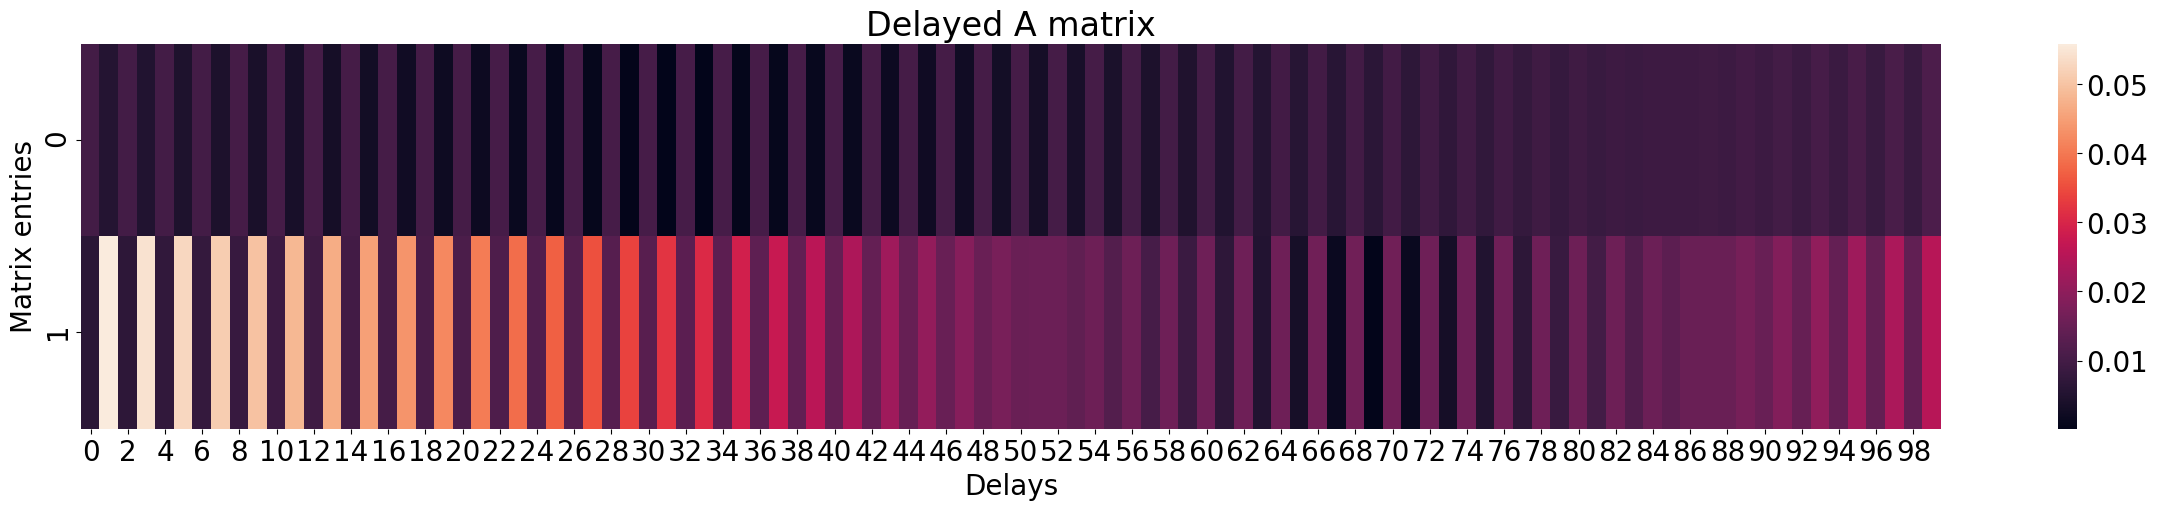

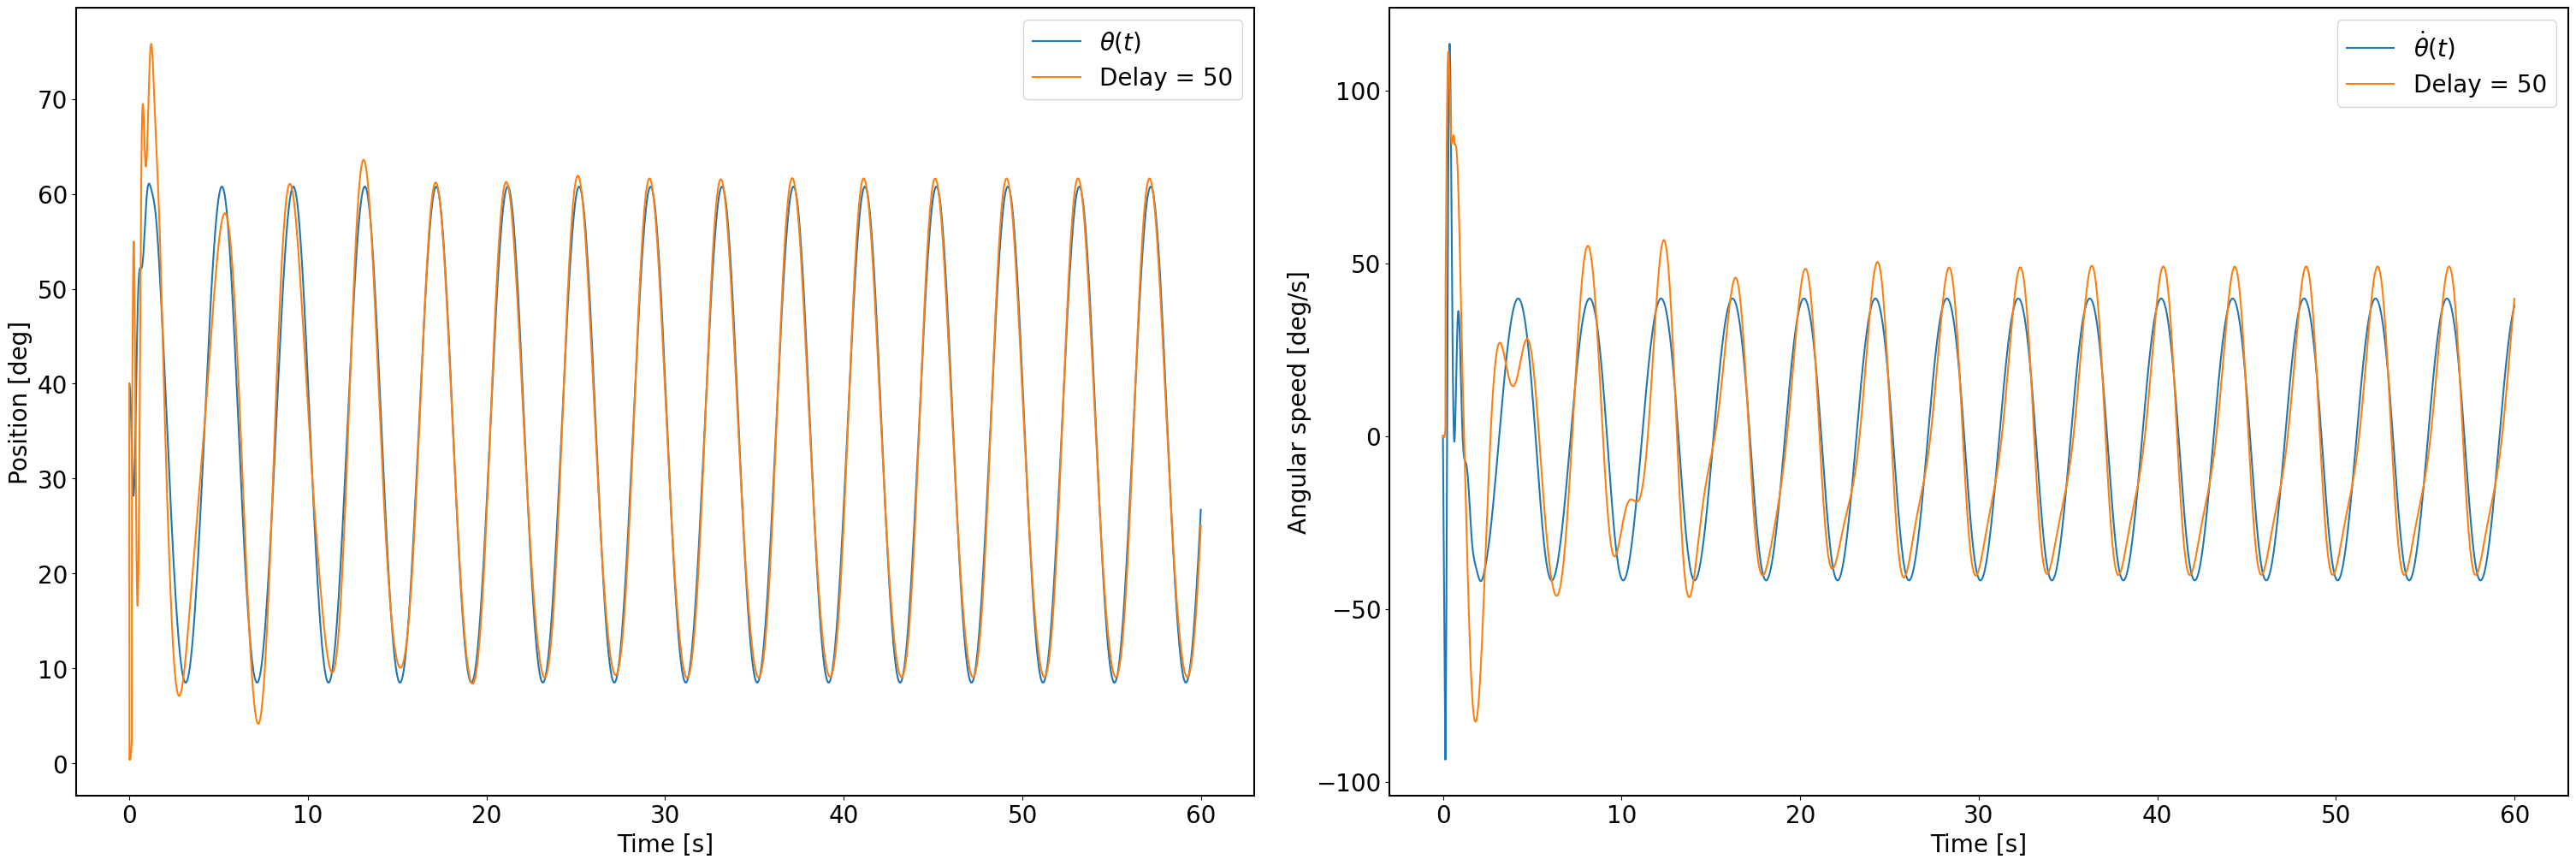

In [183]:
tau = 50
f1 = DelayedLeastSquare(pend.X, tau, horizon, pend.U[:], nb_u=1)
f1.solve(.1)
f1.computeTrajectory(pend.X0, pend.U)

plt.figure(figsize=(30,5))
figA = snb.heatmap(np.abs(f1.A))
plt.title('Delayed A matrix'), plt.xlabel('Delays'), plt.ylabel('Matrix entries')

plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize=(30,10))

ax[0].plot(pend.T, rad2deg(pend.X[0,:]), label=r"$\theta (t)$")
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(pend.T, rad2deg(pend.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg]')
ax[1].grid()
ax[1].legend()

ax[0].plot(pend.T[:len(pend.T)], rad2deg(f1.Traj[0,:]), label='Delay = '+str(tau))
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(pend.T[:len(pend.T)], rad2deg(f1.Traj[1,:]), label='Delay = '+str(tau))
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg/s]')
ax[1].grid()
ax[1].legend()

Train the LQR with the dynamics found with delay embeddings in order to make the rollout of some trajectory, which will then serve as a reference for our model-free controller.

In [184]:
pend = pend2 # For testing
LQR1 = LQR_Transform(f1, pend)
LQR1.LQR_Instance()
LQR1.LQR_setParameters(u_std=0., x_std=1e4)

LQR1.LQR.ricatti()
LQR1.LQR_getK()

### Make LQR rollout

(Text(0.5, 32.16699999999986, 'Delay $\\tau$'),
 Text(922.9431543297185, 0.5, 'Horizon'))

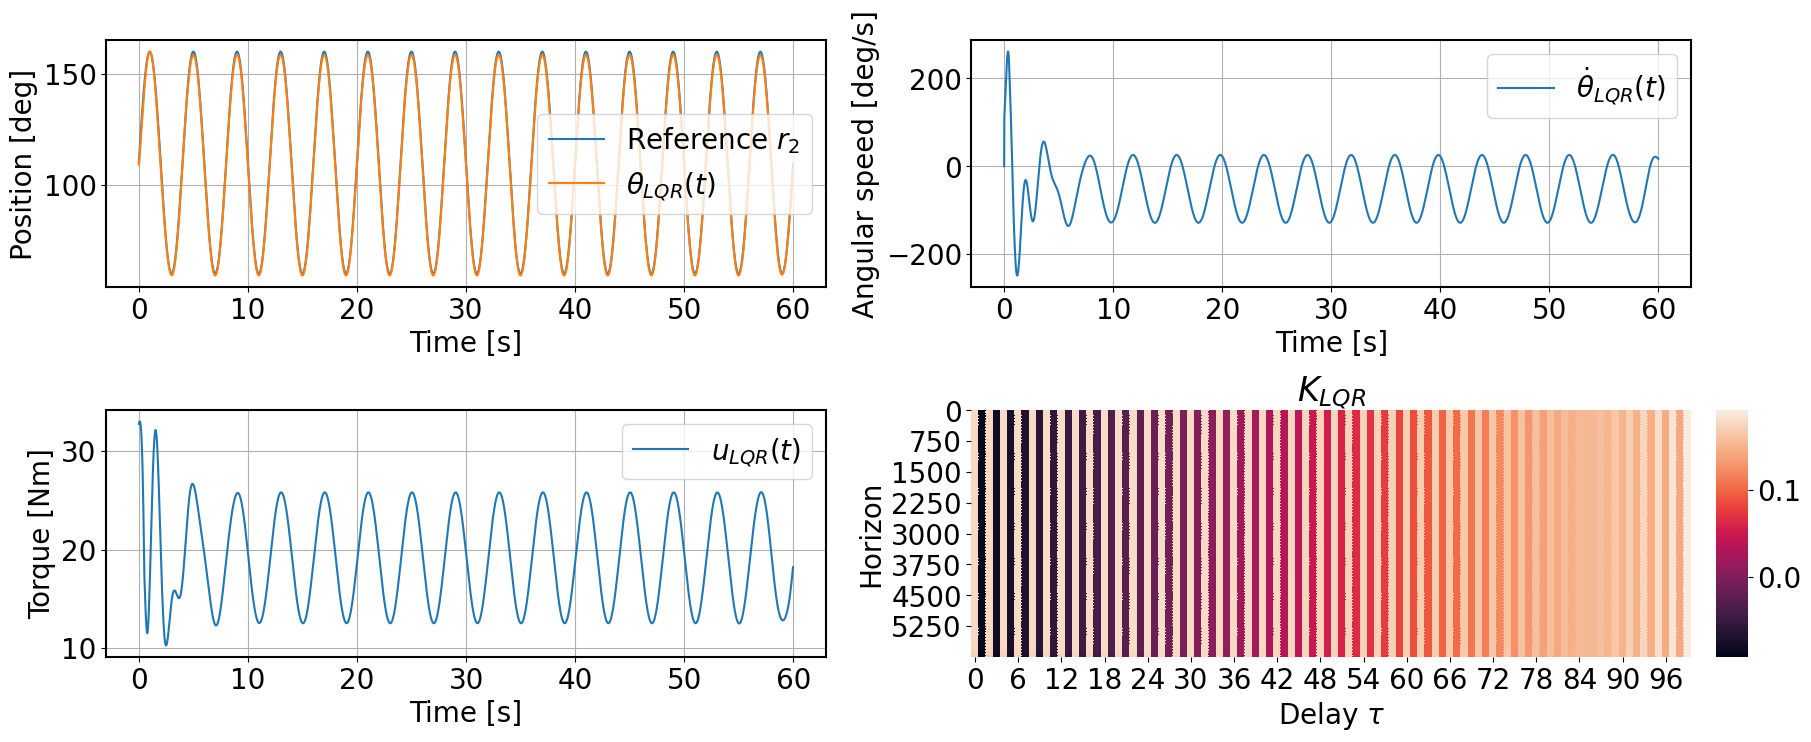

In [185]:
# Simulate the closed-loop system
X0 = np.zeros((10,2*LQR1.tau))
X0[:,0] = pend.X0[0]
LQR1.LQR_rollout(X0)

# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(np.array(pend.ref)), label="Reference $r_2$")
ax[0,0].plot(pend.T, rad2deg(LQR1.X[:,0]), label=r"$\theta_{LQR} (t)$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(LQR1.X[:,1]), label=r"$\dot{\theta}_{LQR} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:f1.N-1], LQR1.us, label='$u_{LQR}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(LQR1.K)
ax[1,1].set_xlabel(r'Delay $\tau$'), ax[1,1].set_ylabel('Horizon')

## Open-loop LQR control

C:\Users\cedri\OneDrive\Documents\Mécanique - EPFL\Master III\Semester project\Software\My code\Subspace-learning-for-robot-application\LQR simulation\Utils\Functions.py:173: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  output[0:2] = np.array((dx1dt,dx2dt))


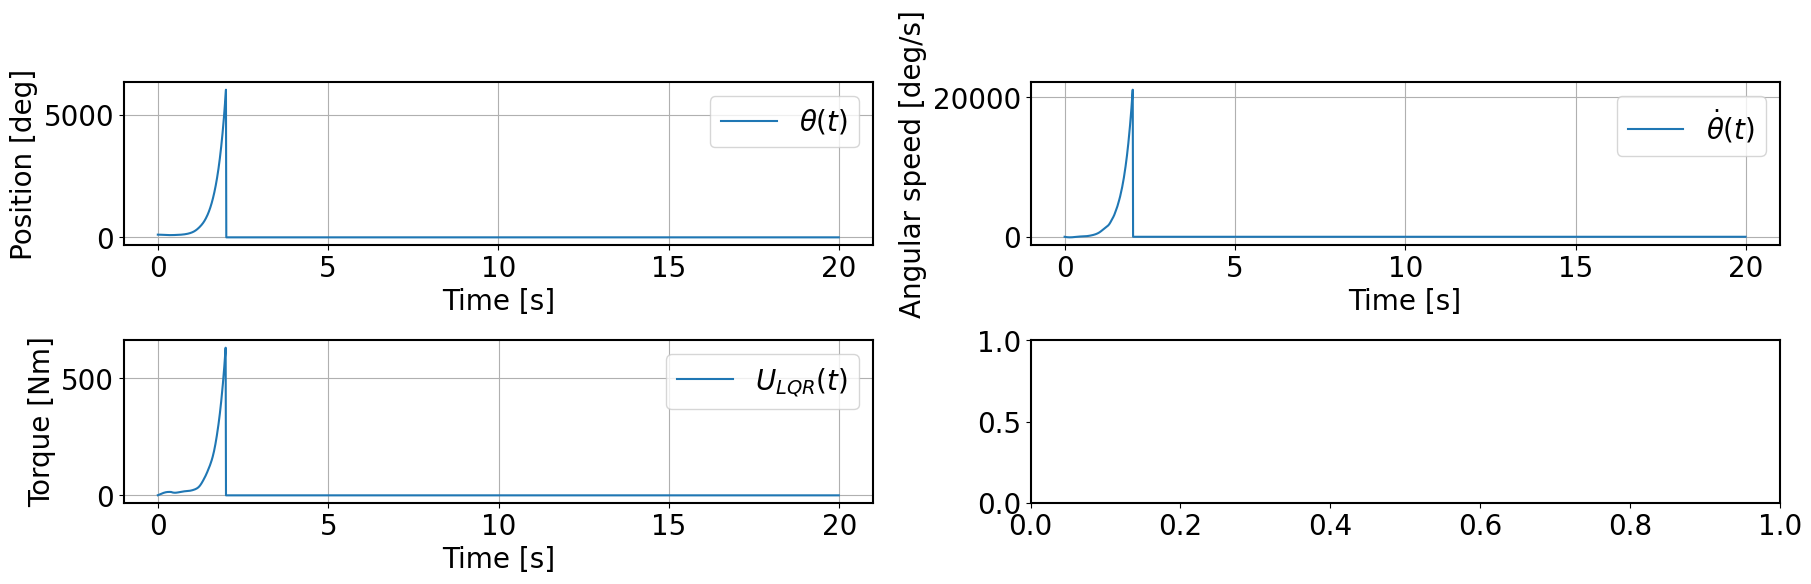

In [77]:
X0 = np.zeros(shape=[2*tau]) # Initial condition : [position [rad], velocity [rad/s]]
X0[0] = deg2rad(110)
t_interval = pend.dt # Time-interval for one step to occur
Xc = np.zeros(shape=[pend.N,2*tau]) # Controlled trajectory
Uc = np.zeros(shape=[pend.N-1]) # Control input history
X_tau = np.zeros(shape=[2*tau]) # Vector for storing all x's past delays
Xc[0,:], X_tau = X0, X0
f = lambda theta, u : pend.dynamicsDelayed(theta, u, tau)
# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(200):
    
#     u = lqr_tracking.get_command(X_tau, i) # Retrieve LQR control input
    K_actual = LQR1.K[i,:]
    u = K_actual@X_tau
    Uc[i] = u
    # Next point of the non-linear controlled trajectory
    Xc[i+1,:] = RK4(f, Xc[i,:], [u], t_interval, type='controller-step-by-step').T
    # Shift elements in delays vector
    X_tau = np.roll(X_tau,2)
    X_tau[0:2] = Xc[i+1,0:2]
    
# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, 
                       constrained_layout = True, figsize=(18,5))

ax[0,0].plot(pend.T, rad2deg(Xc[:,0]), label=r"$\theta (t)$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(Xc[:,1]), label=r"$\dot{\theta} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:pend.N-1], Uc, label=r"$U_{LQR}(t)$")
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

### Model-free control with LQR trajectory as a reference

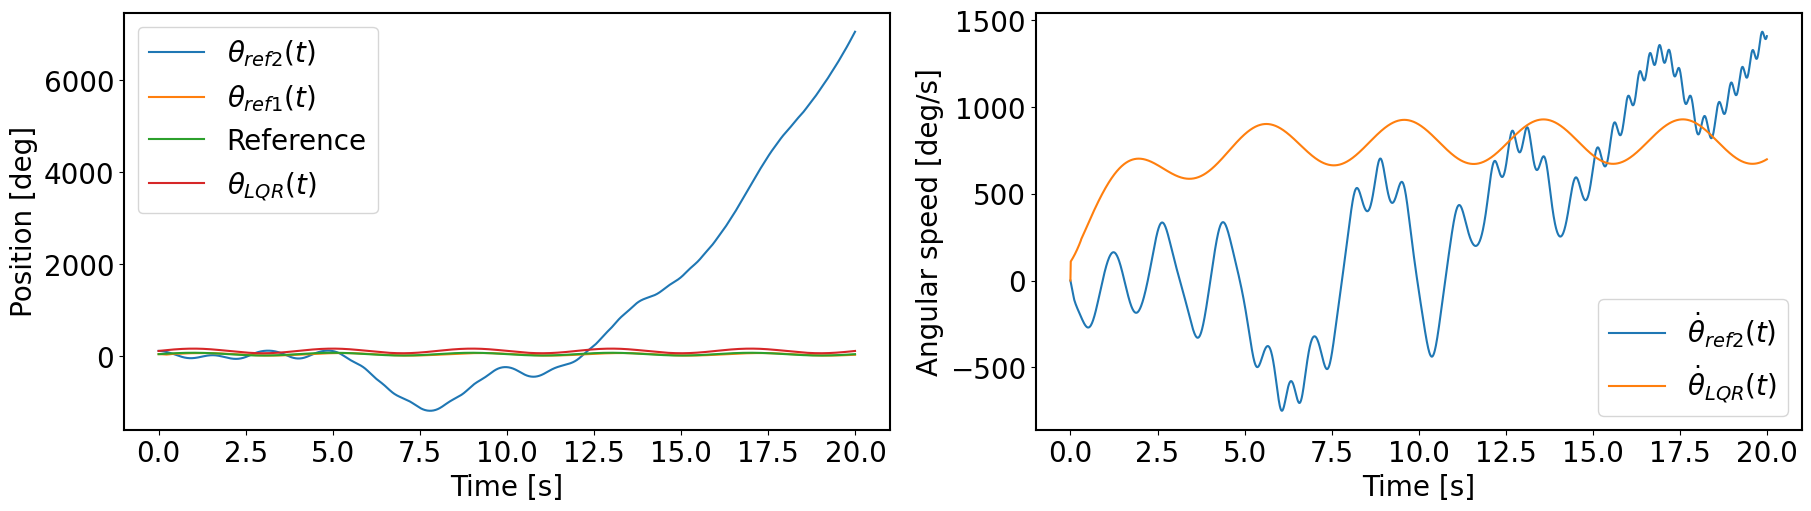

In [62]:
pend.X_ref2[0,:] = pend.X0

for i in range(pend.N-1):
    pend.U2[i] = PID(pend.X, i, LQR1.X[i,0], 10, 0, 33, pend.dt, 10)[0]
    pend.X_ref2[i+1,:] = RK4(pend.dynamics, pend.X_ref2[i,:], pend.U2[i], pend.dt, type='controller-step-by-step')
    
# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(1, 2, constrained_layout = True, figsize=(18,5))

ax[0].plot(pend.T, rad2deg(pend.X_ref2[:,0]), label=r"$\theta_{ref2} (t)$")
ax[0].plot(pend.T, rad2deg(pend.X[0,:]), label=r"$\theta_{ref1} (t)$")
ax[0].plot(pend.T, rad2deg(np.array(pend.ref)), label="Reference")
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(pend.T, rad2deg(pend.X_ref2[:,1]), label=r"$\dot{\theta}_{ref2} (t)$")
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg]')
ax[1].grid()
ax[1].legend()

ax[0].plot(pend.T, rad2deg(LQR1.X[:,0]), label=r"$\theta_{LQR} (t)$")
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(pend.T, rad2deg(LQR1.X[:,1]), label=r"$\dot{\theta}_{LQR} (t)$")
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg/s]')
ax[1].grid()
ax[1].legend()

## Compare the LQR cost of the trajectory with original reference with the one using the LQR rollout reference

In [34]:
# Cost : (trajectory, input, reference)
cost_ref_LQR = LQR1.LQR_cost(pend.X_ref2.T,pend.U2,LQR1.X[:,0])
print('Cost with LQR rollout reference : ',cost_ref_LQR)
cost_ref_std = LQR1.LQR_cost(pend.X,pend.U,pend.ref)
print('Cost with standard reference : ',cost_ref_std)

Cost with LQR rollout reference :  302651.6004312759
Cost with standard reference :  299002.62381315767
